In [59]:
# The code was removed by Watson Studio for sharing.

In [ ]:
# Since all data came in as string we convert them back
"""
from pyspark.sql.functions import col
df = df.select(
        col('TMC').cast('double'),
        col('Severity').cast('int'),
        col('Start_Time').cast('timestamp'),
        col('Start_Lat').cast('double'),
        col('Start_Lng').cast('double'),
        col('Distance(mi)').cast('double'),
        col('Number').cast('double'),
        col('Street').cast('string'),
        col('Side').cast('string'),
        col('City').cast('string'),
        col('County').cast('string'),
        col('State').cast('string'),
        col('Zipcode').cast('string'),
        col('Country').cast('string'),
        col('Timezone').cast('string'),
        col('Airport_Code').cast('string'),
        col('Weather_Timestamp').cast('timestamp'),
        col('Temperature(F)').cast('double'),
        col('Wind_Chill(F)').cast('double'),
        col('Humidity(%)').cast('double'),
        col('Pressure(in)').cast('double'),
        col('Visibility(mi)').cast('double'),
        col('Wind_Direction').cast('string'),
        col('Wind_Speed(mph)').cast('double'),
        col('Precipitation(in)').cast('double'),
        col('Weather_Condition').cast('string'),
        col('Amenity').cast('string'),
        col('Bump').cast('string'),
        col('Crossing').cast('string'),
        col('Give_Way').cast('string'),
        col('Junction').cast('string'),
        col('No_Exit').cast('string'),
        col('Railway').cast('string'),
        col('Roundabout').cast('string'),
        col('Station').cast('string'),
        col('Stop').cast('string'),
        col('Traffic_Calming').cast('string'),
        col('Traffic_Signal').cast('string'),
        col('Turning_Loop').cast('string'),
        col('Sunrise_Sunset').cast('string'),
        col('Civil_Twilight').cast('string'),
        col('Nautical_Twilight').cast('string'),
        col('Astronomical_Twilight').cast('string')
    )
"""

# Functions used to simplify
Some of the following functions are deprecated since they should not be used on the cloud (create spark session, save logs and model)

In [3]:
from pyspark.sql.functions import when, count, col, isnan, countDistinct,from_unixtime,from_utc_timestamp, unix_timestamp,split, to_timestamp, hour, month, lit,collect_list, max
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns 
import matplotlib.pyplot as plt 
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.ml.tuning import CrossValidator
from datetime import datetime
from numpy import argmax

class logging():
    def __init__(self, models_dir, logs_dir, image_dir, foldername, enabled=False):
        self.timeSignature = str(datetime.now().strftime("%Y%m%d%H%M%S"))
        foldername = foldername + "_" +self.timeSignature
        self.models_dir = models_dir + "/" +foldername +"/" 
        self.logs_dir = logs_dir + "/" +foldername + "/logs.md" 
        self.image_dir = image_dir +"/" + foldername +"/" 
        
        self.enabled = enabled
        
        self.createDirectory(self.models_dir, self.logs_dir, self.image_dir)
        
    
    def createDirectory(self,models_folder, logs_folder,image_folder):
        """
        Creates empty folder if it does not exist

        Parameters
        ----------
        models_folder: string
            Path to folder
        logs_folder: string
            Path to folder
        image_folder: string
            Path to folder
        Return
        ----------
        """
        if self.enabled==False: return None
        import os
        try:
            os.makedirs(os.path.dirname(models_folder))
        except:
            pass
        try:
            os.makedirs(os.path.dirname(logs_folder))
        except:
            pass
        try:
            os.makedirs(os.path.dirname(image_folder))
        except:
            pass
        
    def write2file(self, title, info, logs_dir=None):
        """
        Write data to filelog

        Parameters
        ----------
        file: string
            Path to file
        title: string
            Title for info
        info: string
            Data that shall be stored

        Return
        ----------
        """
        
        if self.enabled==False: return None
        if logs_dir == None: logs_dir = self.logs_dir
            
        f = open(logs_dir, "a")
        f.write(f"\n\n# {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} \n__{title}:__\n{info}")
        f.close()
        
    def saveImage(self, image, name, image_dir=None):
        """
        Save file to disk
        Parameters
        ----------
        image: obj
            Image object
        name: string
            Name of file
        image_dir: string, Optional, Default=None
            Alternative path to file

        Return
        ----------
        """
        if self.enabled==False: return None
        if image_dir == None: image_dir = self.image_dir
        try:
            image.figure.savefig(image_dir + name)
        except Exception as e:
            print("Error",e)
            image.savefig(image_dir + name)
            
    def write2fileModel(self, model, model_name, models_dir=None):
        """
        Write the model to filesystem

        Parameters
        ----------
        model: obj
            Model object

        models_dir:
            Directory for the model

        model_name: string
            Name of the model

        timeSignature: string
            Time when program started

        Return
        ----------
        """
        if self.enabled==False: return None
        if models_dir == None: models_dir = self.models_dir
            
        print(f"Saving into: {models_dir}{model_name}")
        try:
            model.write.format('parquet').mode('overwrite').option("header", "true").save(f"{models_dir}/{model_name}")
            print("Saving through format 1")
        except Exception as e:
            print(e)
            model.write().overwrite().save(f"{models_dir}/{model_name}")
            print("Saving through format 2")
           
    def setLogDir(self, logs_dir):
        self.logs_dir = logs_dir
    
    def setModelsDir(self, models_dir):
        self.models_dir = models_dir

def setup_spark(file):
    """
    Setup spark config and server and load datafile
    
    Parameters
    ----------
    file: string
        File to be loaded
    
    Return
    ----------
    """
    try:
        spark.close()
    except: 
        pass

    try:
        conf = SparkConf().setAppName('Spark Project')
        conf.set('spark.driver.memory', '4g')
        conf.set('spark.executor.memory', '4g')
        conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
        conf.set("spark.kryoserializer.buffer.max", "15")
        conf.set('spark.ui.enabled', 'true')
        conf.set('spark.ui.killEnabled', 'false')
        conf.set('spark.serializer.objectStreamReset', '100')
        conf.set('spark.driver.cores', '1')
        conf.set('spark.executor.id', 'driver')
        conf.set('spark.executor.cores', '1')
        conf.set('spark.ui.showConsoleProgress', 'true')
        conf.set('spark.executor.instances', '1')
        conf.set('spark.rdd.compress', 'True')
        sc = SparkContext(conf=conf)
        
        spark = SparkSession.builder \
        .appName("Spark Project") \
        .master("local[*]") \
        .getOrCreate()
        spark.sparkContext.setLogLevel("WARN")
        
    except Exception as e:
        print(e)

    df = spark.read.load(file,format="csv", sep=",", inferSchema="true", header="true")
    return df, sc, spark

def setup_variables(df, sc, colLabel, colRem):
    """
    Creates the column items for category and numerical values.
    
    Parameters
    ----------
    df: Dataframe
        Spark Dataframe
    sc: SparkContext object
        SparkContext object
    colLabel: List
        Items that considered Label
    colRem: List
        Items that should be removed before analysis
    logs_dir: string
        Directory for log file
    Return
    ----------
    df: Dataframe
        Spark Dataframe
    colCat: List
        Items that is considered categories
    colNum: List
        Items that is considered numerical values
    """
    # Dropping data that cant help during model
    df = df.drop(*colRem)

    # Convert boolean to string since PCA cant handle boolean which should be a class
    df = df.select(*[col(c[0]).cast("string").alias(c[0]) if c[1] == 'boolean' else col(c[0]).alias(c[0]) for c in df.dtypes])

    #renamedHousing.select([count(when(col(c).isNull(), c)).alias(c) for c in colNum]).show()
    colCat, colNum = createNewClasses(df, sc, colLabel)

    return df, colCat, colNum

def createNewClasses(df, sc, colLabel):
    """
    Divide the data into classes
    
    Parameters
    ----------
    df: Dataframe
        Spark Dataframe
    sc: SparkContext object
        SparkContext object
    colLabel: List
        Items that considered Label
        
    logs_dir: string
        Directory for log file
        
    Return
    ----------
    colCat: List
        Items that is considered categories
    colNum: List
        Items that is considered numerical values
    """
    rdd = sc.parallelize(df.dtypes)
    
    colCat = rdd.map(lambda i: i[0] if (i[1]=='string' or i[1]=='boolean' and i[0] not in colLabel) else None).filter(lambda i: i != None).collect()
    colNum = rdd.map(lambda i: i[0] if (i[1]=='double' and i[0] not in colLabel) else None).filter(lambda i: i != None).collect()
    
    print(f"Label: {colLabel} \nCategories: {colCat}\nNumerical: {colNum}")
    return colCat, colNum 

def printMissingValues(df, logger):
    """
    Print missing values in Dataframe
    
    Parameters
    ----------
    df: Dataframe
        Spark Dataframe
    logs_dir: string
        Directory for log file
        
    Return
    ----------
    """
    # Check data
    df_missingVals_cols = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

    # Missing value in each column
    tmp = df_missingVals_cols.collect()
    logger.write2file("Missing values", str(tmp))
    print("Missing values" + str(tmp))
    
def printCategoricalValues(df, colCat, logger):
    """
    Print the count of unique values from categories
    
    Parameters
    ----------
    df: Dataframe
        Spark Dataframe
    colCat: List
        Items that is considered categories
    logs_dir: string
        Directory for log file
        
    Return
    ----------
    """
    # Checking how many classes that can be used
    tmp = [df.select(countDistinct(c).alias(c)).collect()[0] for c in colCat] 
    print("Unique column values:", tmp)

    logger.write2file("Categorical values", str(tmp))

def evaluateModel(estimator, 
                  paramGrid, 
                  modelType, 
                  trainSet, 
                  testSet, 
                  evaluator, 
                  k=10,
                  seed=None,
                  logger=None):
    """
    Evaluate model through CrossValidator, save model, and check accuracy
    
    Parameters
    ----------
    estimator: Obj
        Algorithm used for fitting model
    paramGrid: paramGrid
        Params that will be tested and evaluated
    modelType: string
        Name of the model
    trainSet: Dataframe
        Training set
    testSet: Dataframe
        Test set
    timeSignature: string
        Time when program started
    evaluator: Obj, Optional, Default: MulticlassClassificationEvaluator
        Evaluator
    k: int
        Number of folds
    seed:
        Seed
    logs_dir: string
        Directory for log file
    models_dir:
        Directory for the model
    Return
    ----------
    model: Obj
        Model that is fitted
    predictions: obj
        Predictions that is transformed based on the model and testSet
    """
    cv =  CrossValidator(estimator=estimator, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=k, seed=seed) 
    
    print("Fitting model..")
    logger.write2file("Fitting "+str(modelType)+" model..","")
    
    model = cv.fit(trainSet)
    
    print("Predicting on testSet..")
    logger.write2file("Predicting "+str(modelType)+" on testSet..","")
    
    predictions = model.transform(testSet)
    samplePredict = predictions.select("prediction", "label", "features")
    
    print("Evaluating predictions..")
    logger.write2file("Evaluating "+ str(modelType) +" predictions..","")
    
    accuracy = evaluator.evaluate(predictions)
    params = model.getEstimatorParamMaps()[argmax(model.avgMetrics)]
    
    logger.write2file("Evaluating "+ str(modelType),"Display 5 datapoints:\n" + str(samplePredict.take(5)) + "\nAccuracy: " + str(accuracy)+"\nParameters:\n" + str(params))
    logger.write2fileModel(model, str(modelType))
    samplePredict.show(5)
    print("Accuracy: ",accuracy, "\nParameters\n",params)

    predLabel = predictions.select([col('label').cast('float'),col('prediction').cast('float')])
    metrics = MulticlassMetrics(predLabel.rdd)

    print("Confusion matrix:", metrics.confusionMatrix())

    
    return model, predictions

# Import

In [4]:
from datetime import datetime
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler,OneHotEncoderEstimator,QuantileDiscretizer, StringIndexer, Imputer,StandardScaler,MinMaxScaler
from pyspark.sql.functions import udf
from pyspark.ml.linalg import SparseVector, VectorUDT
from pyspark.ml import Pipeline
from pyspark.ml.feature import ChiSqSelector,PCA
from pyspark.sql.types import DoubleType

from pyspark.ml.classification import LogisticRegression,DecisionTreeClassifier,RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator

# Setup environment

In [5]:
model_indexing_dir = "log_index.md"
images_dir = "analysis"
models_dir = "models"
logs_dir = "models" 
filter_state = 'CA' # ALL if all states
model_Note = ''
log_mode=False # Logs data to files, Dont use on massive dataset (debug_mode is recommended while on)
debug_mode=False # Reduce number of rows collected for faster processing
enable_plots = True # Dont use unless debug_mode is on, or datasize is small
logger = logging(models_dir, logs_dir, images_dir, filter_state, enabled=log_mode)

file = "data/US_Accidents_Dec19.csv"


#df, sc,spark = setup_spark(file) # Uncomment in order to run it locally!

# Define Columns

In [6]:
colLabel = ["Severity"]

colRem = ['ID', 
          'Source',
          'End_Time',
          'End_Lat',
          'End_Lng',
          'Description',
        ]

df, colCat, colNum = setup_variables(df, sc, colLabel, colRem)  

logger.write2file("Number of rows", str(df.count()))
logger.write2file("Categorical groups","Defined Label:\n" + str(colLabel) + "\nDefined Categories:\n" + str(colCat) + "\nDefined Numerical:\n" +str(colNum))

Label: ['Severity'] 
Categories: ['Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Wind_Direction', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
Numerical: ['TMC', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Number', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']


In [7]:
sc

<SparkContext master=local[*] appName=Spark Project>

In [8]:
tmp = sc._conf.getAll()
logger.write2file("New Spark session", str(tmp))
print("Config:",tmp)

Config: [('spark.driver.memory', '4g'), ('spark.executor.memory', '4g'), ('spark.driver.host', '4082e07eadd9'), ('spark.ui.enabled', 'true'), ('spark.executor.id', 'driver'), ('spark.driver.port', '36745'), ('spark.app.name', 'Spark Project'), ('spark.ui.killEnabled', 'false'), ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'), ('spark.app.id', 'local-1589841493391'), ('spark.rdd.compress', 'True'), ('spark.serializer.objectStreamReset', '100'), ('spark.executor.instances', '1'), ('spark.master', 'local[*]'), ('spark.executor.cores', '1'), ('spark.submit.deployMode', 'client'), ('spark.kryoserializer.buffer.max', '15'), ('spark.ui.showConsoleProgress', 'true'), ('spark.driver.cores', '1')]


# Debug tool

In [ ]:
if debug_mode == True: 
    df.createOrReplaceTempView("records")
    reviewData = spark.sql("SELECT * FROM records LIMIT 100000") 

df.count()

# 1. Analysis 

In [9]:
print(f"Categories:\n \
Labels: {len(colLabel)}\n \
Classes: {len(colCat)}\n \
Removed: {len(colRem)}\n \
Numerical: {len(colNum)}") 

info = f"Rows: {df.count()}\nColumns {len(df.columns)}"
print(info)
df.printSchema()
df.take(1)

logger.write2file("Data analysis",info +"\n"+ str(df._jdf.schema().treeString()) + str(df.take(1)))

Categories:
 Labels: 1
 Classes: 28
 Removed: 6
 Numerical: 12
Rows: 2925212
Columns 43
root
 |-- TMC: double (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Number: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Visibility(mi): double (nullable = true)

## Statistical summary

In [10]:
df.describe(colNum).show()

+-------+------------------+-----------------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+----------------+--------------------+
|summary|               TMC|        Start_Lat|         Start_Lng|       Distance(mi)|            Number|    Temperature(F)|    Wind_Chill(F)|       Humidity(%)|      Pressure(in)|   Visibility(mi)| Wind_Speed(mph)|   Precipitation(in)|
+-------+------------------+-----------------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+----------------+--------------------+
|  count|           2246264|          2925212|           2925212|            2925211|           1044257|           2870369|          1074342|           2867292|           2878158|          2860864|         2485981|              929628|
|   mean|207.83163198982845|36.45789080583485|-95.314806

## Get missing data

In [11]:
printMissingValues(df, logger)

Missing values[Row(TMC=678948, Severity=0, Start_Time=0, Start_Lat=0, Start_Lng=0, Distance(mi)=1, Number=1880955, Street=1, Side=1, City=84, County=1, State=1, Zipcode=804, Country=1, Timezone=2974, Airport_Code=5437, Weather_Timestamp=35687, Temperature(F)=54843, Wind_Chill(F)=1850870, Humidity(%)=57920, Pressure(in)=47054, Visibility(mi)=64348, Wind_Direction=43491, Wind_Speed(mph)=439231, Precipitation(in)=1995584, Weather_Condition=64557, Amenity=1, Bump=1, Crossing=1, Give_Way=1, Junction=1, No_Exit=1, Railway=1, Roundabout=1, Station=1, Stop=1, Traffic_Calming=1, Traffic_Signal=1, Turning_Loop=1, Sunrise_Sunset=94, Civil_Twilight=94, Nautical_Twilight=94, Astronomical_Twilight=94)]


## Get categorical values

In [12]:
df.persist()
tmp = [df.select(countDistinct(c).alias(c)).collect()[0] for c in [*colCat]] 
df.unpersist()
print("Unique column values:", tmp)

logger.write2file("Unique column values", str(tmp))

Unique column values: [Row(Street=159491), Row(Side=3), Row(City=11631), Row(County=1704), Row(State=49), Row(Zipcode=374288), Row(Country=1), Row(Timezone=4), Row(Airport_Code=1990), Row(Wind_Direction=24), Row(Weather_Condition=119), Row(Amenity=2), Row(Bump=2), Row(Crossing=2), Row(Give_Way=2), Row(Junction=2), Row(No_Exit=2), Row(Railway=2), Row(Roundabout=2), Row(Station=2), Row(Stop=2), Row(Traffic_Calming=2), Row(Traffic_Signal=2), Row(Turning_Loop=1), Row(Sunrise_Sunset=2), Row(Civil_Twilight=2), Row(Nautical_Twilight=2), Row(Astronomical_Twilight=2)]


## Correlation

In [13]:
print([*colNum, *colLabel])

['TMC', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Number', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Severity']


In [14]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

assembler = VectorAssembler(
    inputCols=colNum,
    outputCol="features",
    handleInvalid = "skip")

df_attributes = assembler.transform(df)
df_attributes.select("features").show(1,False)



r1 = Correlation.corr(df_attributes, "features").head()

print("correlation matrix:\n" + str(r1[0]))

logger.write2file("Correlation matrix", str(r1[0]))

+---------------------------------------------------------------------------+
|features                                                                   |
+---------------------------------------------------------------------------+
|[201.0,39.972038,-82.913521,0.01,3280.0,37.4,33.8,100.0,29.62,3.0,4.6,0.02]|
+---------------------------------------------------------------------------+
only showing top 1 row

correlation matrix:
DenseMatrix([[ 1.00000000e+00, -3.29968079e-02, -4.23709318e-02,
               6.48521350e-02,  4.88102771e-02,  2.89427459e-02,
               3.07391705e-02, -6.70493470e-03,  4.59513996e-03,
               2.21819466e-02, -1.61669692e-03, -1.80310455e-03],
             [-3.29968079e-02,  1.00000000e+00, -5.22492702e-03,
               5.01751676e-02, -3.17558810e-02, -4.68351247e-01,
              -4.69159899e-01,  9.79378608e-02, -1.18202158e-01,
              -1.54998940e-01,  9.15359600e-02,  5.03876348e-03],
             [-4.23709318e-02, -5.22492702e-

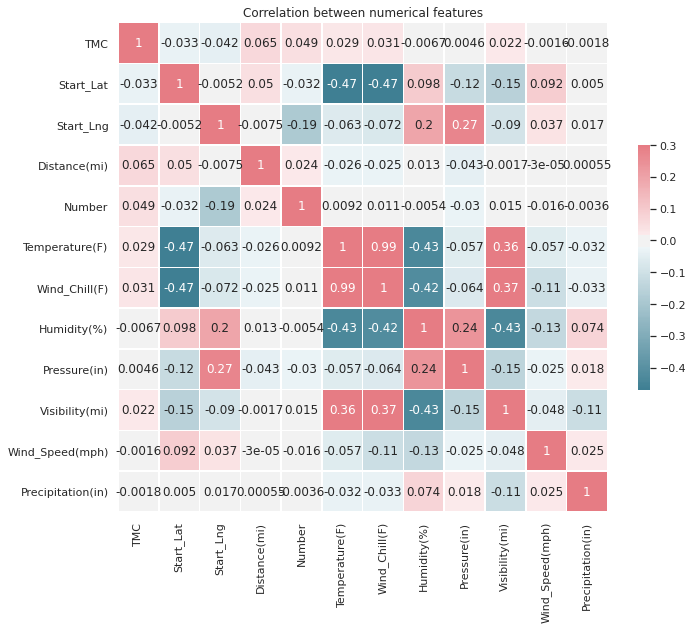

In [15]:
if enable_plots == True:
    sns.set(style="white")
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    b = sns.heatmap(r1[0].toArray().tolist(), annot=True, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5},xticklabels=colNum,yticklabels=colNum,ax=ax )
    ax.set_title("Correlation between numerical features")

    logger.saveImage(b,"feature_corr_matrix")

## Severity

In [16]:
severity_freq = df.groupBy('Severity').count().orderBy('count',ascending=False)
severity_freq.take(10)

[Row(Severity=2, count=1959478),
 Row(Severity=3, count=878985),
 Row(Severity=4, count=85781),
 Row(Severity=1, count=968)]

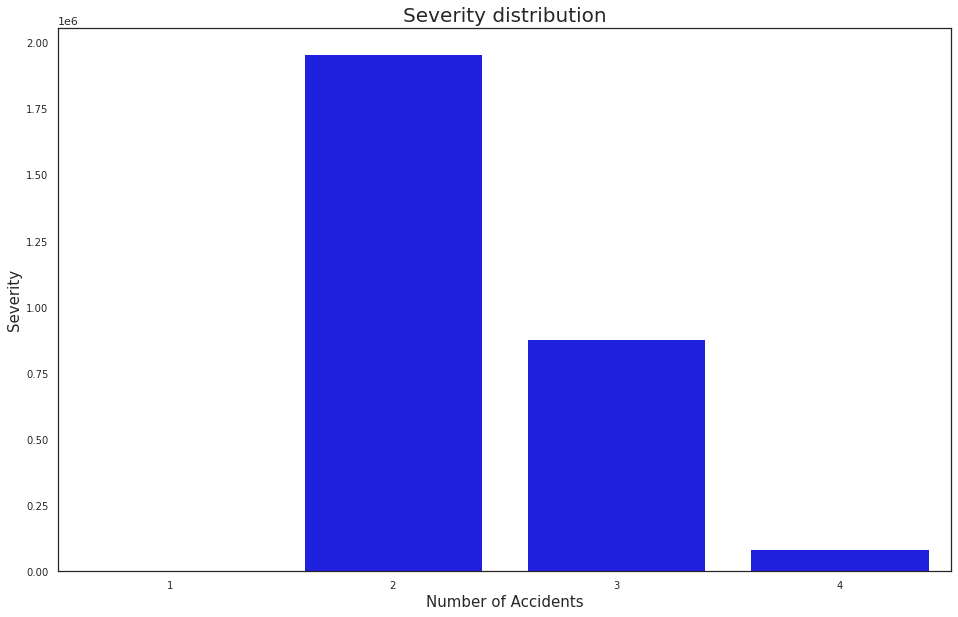

In [17]:
if enable_plots == True:
    pd_severity = severity_freq.toPandas()

    # Plot data
    fig,ax = plt.subplots(figsize=(16,10))
    b = sns.barplot(pd_severity['Severity'],pd_severity['count'], color='blue')
    b.axes.set_title("Severity distribution",fontsize=20)
    b.set_xlabel("Number of Accidents",fontsize=15)
    b.set_ylabel("Severity",fontsize=15)
    b.tick_params(labelsize=10)

    logger.saveImage(b,"severity_dist")

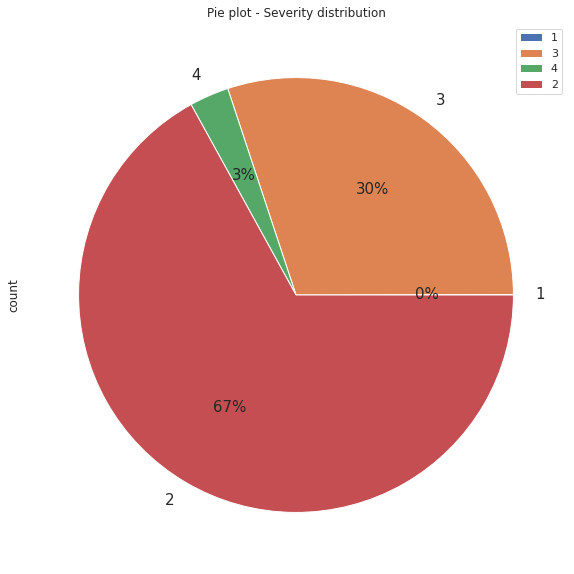

In [18]:
if enable_plots == True:
    df_sev = df.groupby('Severity').count().toPandas()
    fig = df_sev.plot.pie(y='count', labels=df_sev['Severity'], figsize=(10, 10), autopct='%1.0f%%',title="Pie plot - Severity distribution",fontsize=15)
    logger.saveImage(fig,"pie_severity_dist")
    

## Causes

### Frequency of severity and state

In [19]:
state_freq = df.groupBy('State').count().orderBy('count',ascending=False)
state_freq.take(10)

[Row(State='CA', count=653172),
 Row(State='TX', count=296044),
 Row(State='FL', count=220711),
 Row(State='SC', count=146340),
 Row(State='NC', count=141384),
 Row(State='NY', count=135622),
 Row(State='PA', count=90015),
 Row(State='MI', count=87425),
 Row(State='IL', count=84759),
 Row(State='GA', count=82073)]

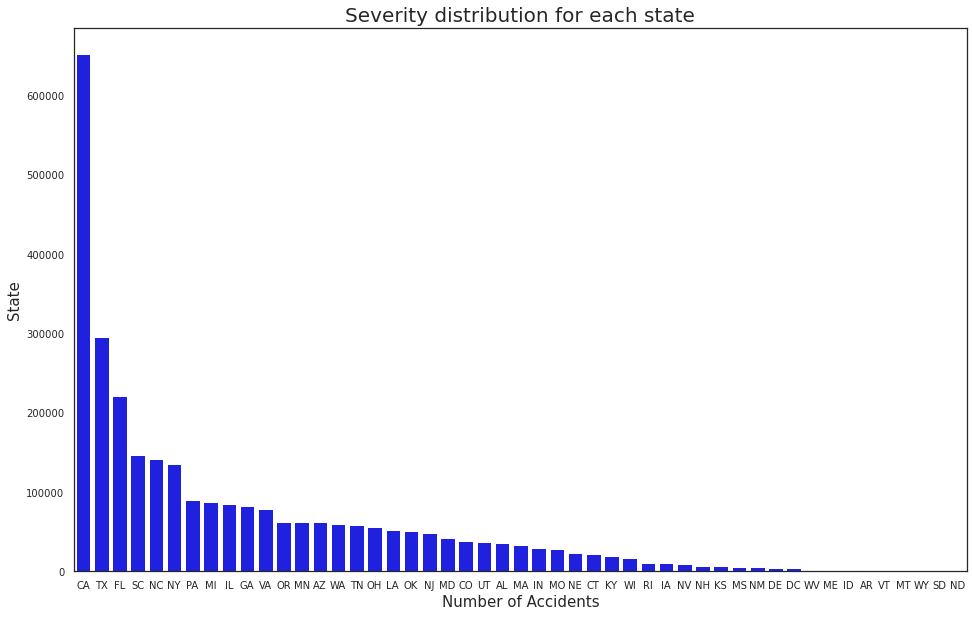

In [20]:
if enable_plots == True:
    pd_states = state_freq.toPandas()

    # Plot data
    fig,ax = plt.subplots(figsize=(16,10))
    b = sns.barplot(pd_states['State'],pd_states['count'], color='blue')
    b.axes.set_title("Severity distribution for each state",fontsize=20)
    b.set_xlabel("Number of Accidents",fontsize=15)
    b.set_ylabel("State",fontsize=15)
    b.tick_params(labelsize=10)

    logger.saveImage(b,"severity_dist_state")

In [21]:
state_severity_freq = df.groupBy('State','Severity').count().orderBy('count',ascending=False)
state_severity_freq.take(10)

[Row(State='CA', Severity=2, count=436981),
 Row(State='TX', Severity=2, count=214216),
 Row(State='CA', Severity=3, count=210069),
 Row(State='FL', Severity=2, count=142957),
 Row(State='NC', Severity=2, count=120643),
 Row(State='SC', Severity=2, count=114096),
 Row(State='NY', Severity=2, count=80954),
 Row(State='TX', Severity=3, count=78460),
 Row(State='FL', Severity=3, count=70953),
 Row(State='PA', Severity=2, count=67629)]

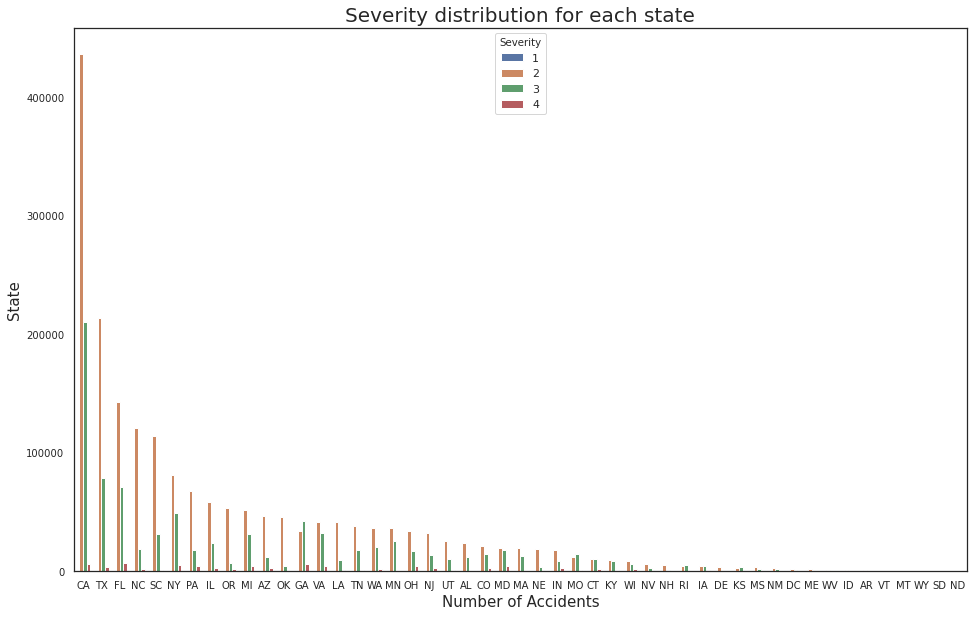

In [22]:
if enable_plots == True:
    pd_state_severity = state_severity_freq.toPandas()

    # Plot data
    fig,ax = plt.subplots(figsize=(16,10))
    b = sns.barplot(x="State", y="count", hue="Severity", data=pd_state_severity)
    #b = sns.barplot(pd_state_severity['State', 'Severity'],pd_state_severity['count'])
    b.axes.set_title("Severity distribution for each state",fontsize=20)
    b.set_xlabel("Number of Accidents",fontsize=15)
    b.set_ylabel("State",fontsize=15)
    b.tick_params(labelsize=10)

    logger.saveImage(b,"severity_dist_class_state")

### Weather conditions

In [23]:
weather_freq = df.groupBy('Weather_Condition').count().orderBy('count',ascending=False)
weather_freq.take(10)

[Row(Weather_Condition='Clear', count=808171),
 Row(Weather_Condition='Mostly Cloudy', count=405136),
 Row(Weather_Condition='Overcast', count=382479),
 Row(Weather_Condition='Fair', count=311864),
 Row(Weather_Condition='Partly Cloudy', count=288380),
 Row(Weather_Condition='Scattered Clouds', count=204662),
 Row(Weather_Condition='Light Rain', count=139622),
 Row(Weather_Condition='Cloudy', count=109817),
 Row(Weather_Condition=None, count=64557),
 Row(Weather_Condition='Light Snow', count=42109)]

[Row(Weather_Condition='Clear', count=808171), Row(Weather_Condition='Mostly Cloudy', count=405136), Row(Weather_Condition='Overcast', count=382479), Row(Weather_Condition='Fair', count=311864), Row(Weather_Condition='Partly Cloudy', count=288380), Row(Weather_Condition='Scattered Clouds', count=204662), Row(Weather_Condition='Light Rain', count=139622), Row(Weather_Condition='Cloudy', count=109817), Row(Weather_Condition=None, count=64557), Row(Weather_Condition='Light Snow', count=42109), Row(Weather_Condition='Haze', count=33932), Row(Weather_Condition='Rain', count=32585), Row(Weather_Condition='Fog', count=21853), Row(Weather_Condition='Heavy Rain', count=11966), Row(Weather_Condition='Light Drizzle', count=10201), Row(Weather_Condition='Light Thunderstorms and Rain', count=4928), Row(Weather_Condition='Snow', count=4795), Row(Weather_Condition='Thunderstorm', count=4438), Row(Weather_Condition='Smoke', count=3558), Row(Weather_Condition='Fair / Windy', count=3547)]


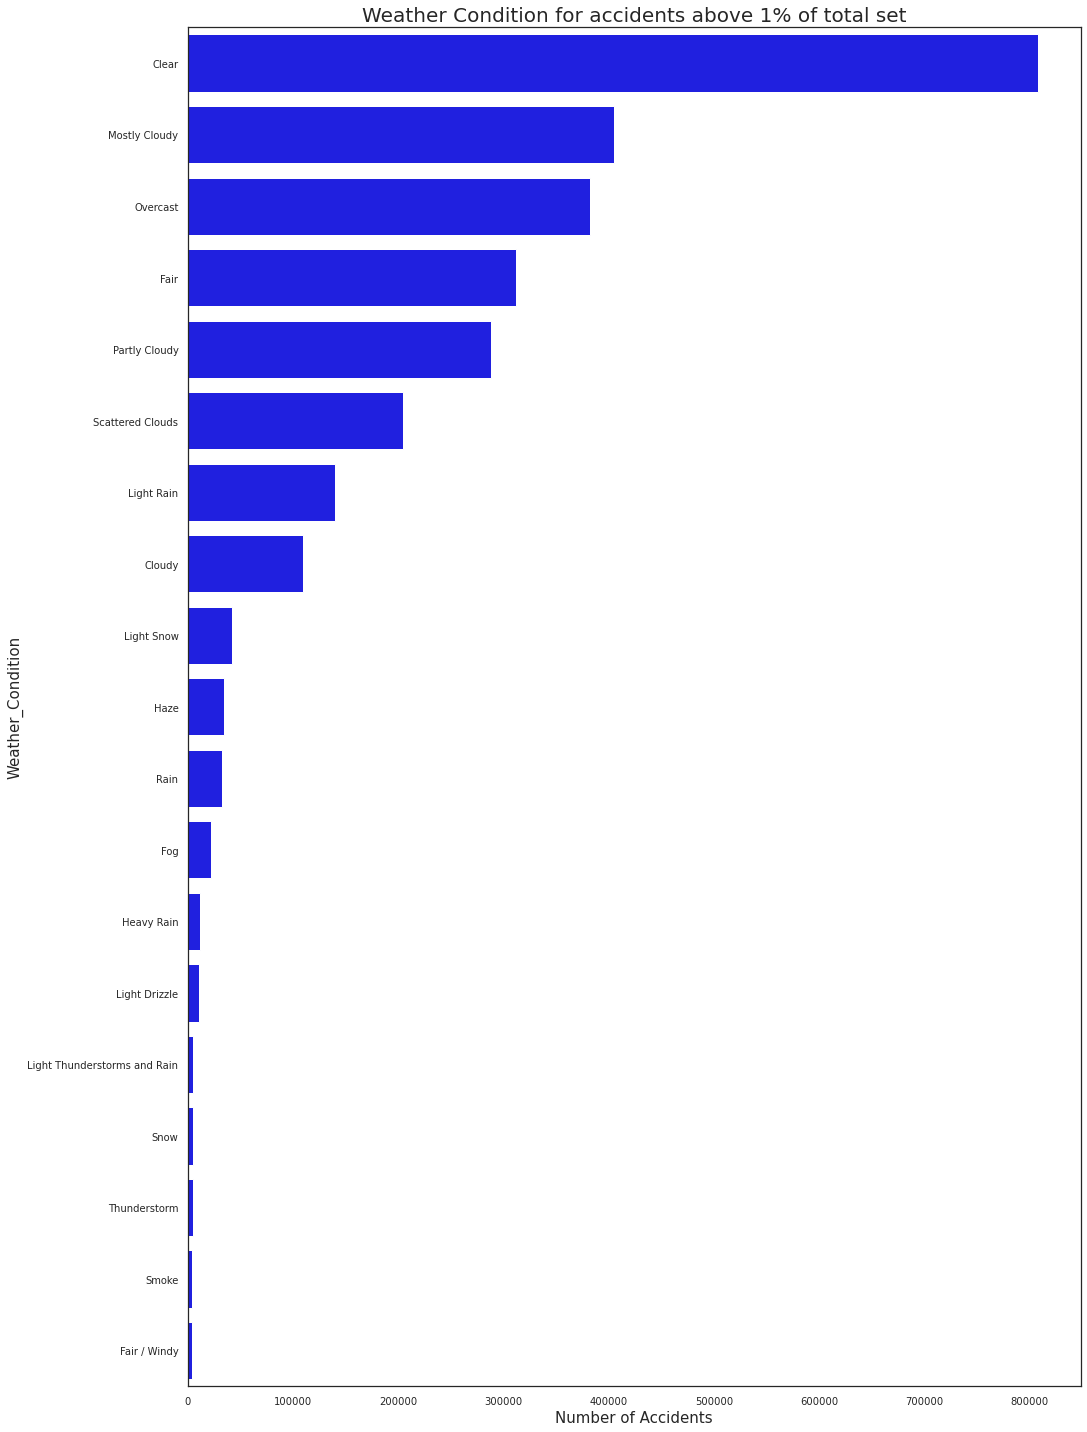

In [24]:

n = int(df.count()*0.001) # Limit the plot to ignore conditions below an limit

rdd_filtered = weather_freq.rdd.filter(lambda x: x['count'] > n)
print(rdd_filtered.collect())

if enable_plots == True:
    fig, ax=plt.subplots(figsize=(16,25))
    pd_weather = rdd_filtered.toDF().toPandas()

    b = sns.barplot(pd_weather['count'][:],pd_weather['Weather_Condition'][:], color="blue")

    b.axes.set_title("Weather Condition for accidents above 1% of total set",fontsize=20)
    b.set_xlabel("Number of Accidents",fontsize=15)
    b.set_ylabel("Weather_Condition",fontsize=15)
    b.tick_params(labelsize=10)

    logger.saveImage(b,"weather_cond_dist")
    logger.write2file("Weather condition distribution", str(pd_weather))

### Time when accidents occured

In [25]:
df_time = df.selectExpr("hour(to_timestamp(from_utc_timestamp(Start_Time, Timezone), 'yyyy-MM-dd HH:mm:ss')) as Start_Time")
time_freq = df_time.groupBy('Start_Time').count().orderBy('count',ascending=False)
time_freq.take(10)

[Row(Start_Time=3, count=249235),
 Row(Start_Time=2, count=225145),
 Row(Start_Time=4, count=207490),
 Row(Start_Time=11, count=182422),
 Row(Start_Time=12, count=182094),
 Row(Start_Time=10, count=177869),
 Row(Start_Time=1, count=166845),
 Row(Start_Time=9, count=161333),
 Row(Start_Time=5, count=159849),
 Row(Start_Time=13, count=152495)]

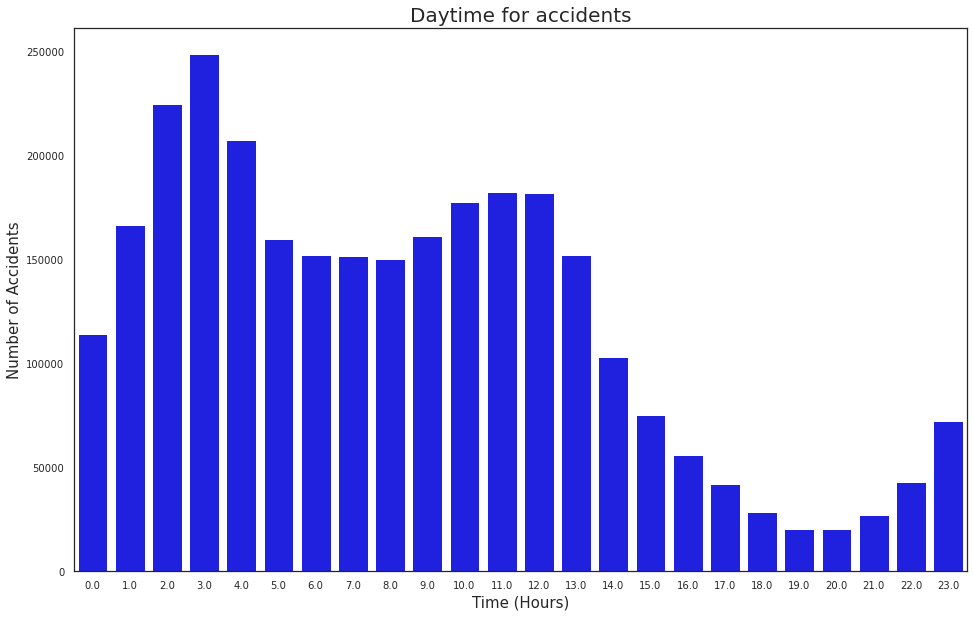

In [26]:
if enable_plots == True:
    pd_time = time_freq.toPandas()
 
    # Plot data
    fig,ax = plt.subplots(figsize=(16,10))

    b = sns.barplot(pd_time['Start_Time'],pd_time['count'], color='blue')
    b.axes.set_title("Daytime for accidents",fontsize=20)
    b.set_xlabel("Time (Hours)",fontsize=15)
    b.set_ylabel("Number of Accidents",fontsize=15)
    b.tick_params(labelsize=10)

    logger.saveImage(b,"accident_hours")

### Development of accidents on Month basis

In [27]:
df_time = df.selectExpr("month(to_timestamp(from_utc_timestamp(Start_Time, Timezone), 'yyyy-MM-dd HH:mm:ss')) as Start_Time")
time_freq = df_time.groupBy('Start_Time').count().orderBy('count',ascending=False)
time_freq.take(10)

[Row(Start_Time=10, count=324135),
 Row(Start_Time=12, count=299258),
 Row(Start_Time=11, count=298801),
 Row(Start_Time=9, count=292194),
 Row(Start_Time=8, count=271266),
 Row(Start_Time=4, count=211033),
 Row(Start_Time=1, count=209776),
 Row(Start_Time=7, count=208727),
 Row(Start_Time=3, count=206805),
 Row(Start_Time=5, count=204974)]

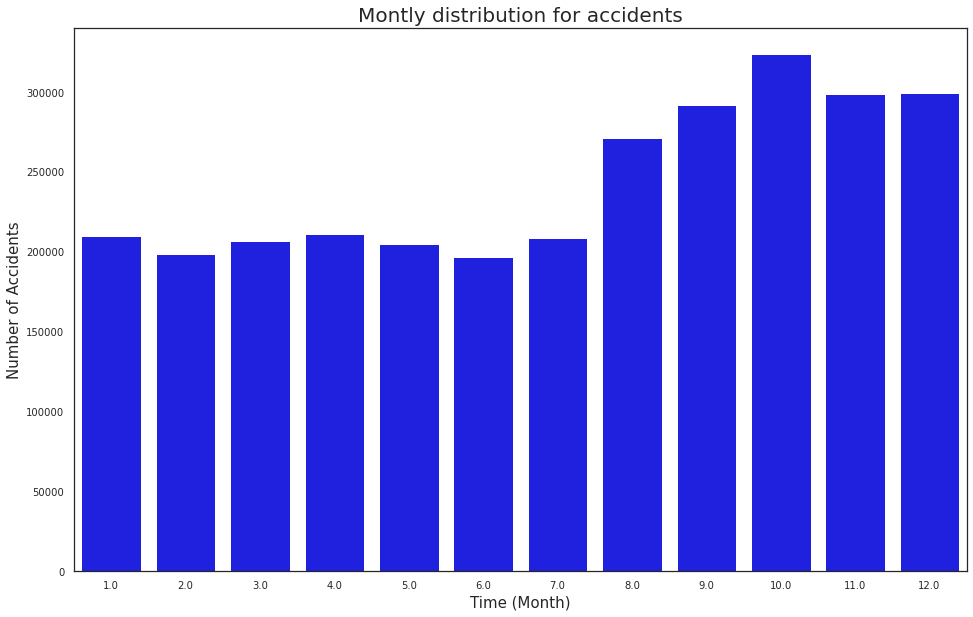

In [28]:
if enable_plots == True:
    pd_time = time_freq.toPandas()

    # Plot data
    fig,ax = plt.subplots(figsize=(16,10))

    b = sns.barplot(pd_time['Start_Time'],pd_time['count'], color='blue')
    b.axes.set_title("Montly distribution for accidents",fontsize=20)
    b.set_xlabel("Time (Month)",fontsize=15)
    b.set_ylabel("Number of Accidents",fontsize=15)
    b.tick_params(labelsize=10)

    logger.saveImage(b,"accidents_months")

### Map distribution

Error 'JointGrid' object has no attribute 'figure'


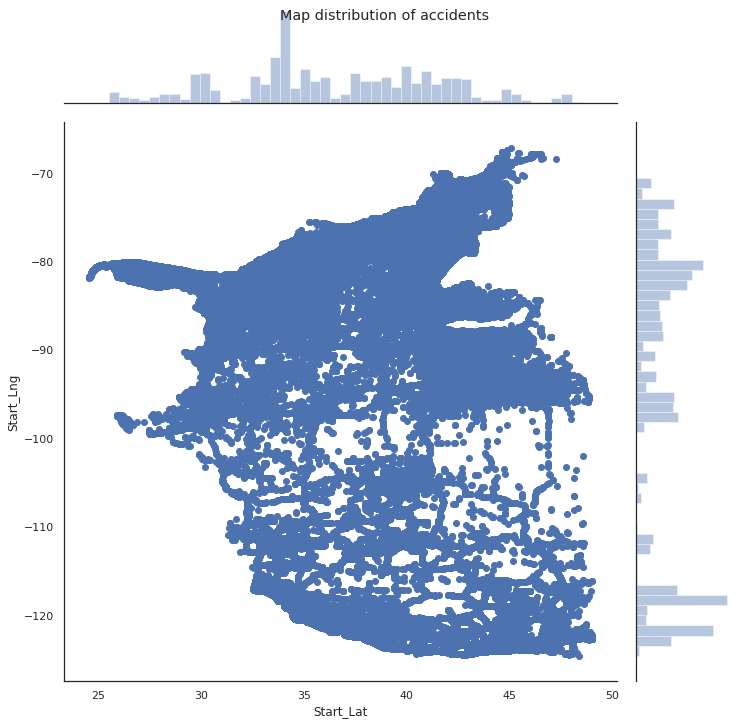

In [29]:
if enable_plots == True:
    b = sns.jointplot(x=df.select('Start_Lat').toPandas(),y=df.select('Start_Lng').toPandas(),height=10)
    b.set_axis_labels('Start_Lat','Start_Lng')
    b.fig.suptitle("Map distribution of accidents")
    logger.saveImage(b,"accident_map_dist")

In [30]:
logger.write2file("New Analysis created!", \
               "Model finished: Yes" + \
               "\nFolder name: " + logger.timeSignature + \
               "\nState: "+ "Not defined" + \
               "\nLogs directory: " + logger.logs_dir +  \
               "\nFile: " + file + \
               "\nNote: " + model_Note, \
               logs_dir=model_indexing_dir \
              )

# 2. Preprocessing

## Analyse single state
#This could be CA since it stands for a little less than 50% of the total set

In [31]:
if filter_state != 'ALL':
    df = df.filter(df.State == filter_state) # Lowers the dataset quite a lot
    logger.write2file("Specified state",str(filter_state))
else:
    logger.write2file("No state specified","")

## Modify time
#Convert the timestamp into a numeric value and then into a string so that the time of day and month can be categorised.

In [32]:
# Convert to int then cast to string

df = df.withColumn('Start_Hour', hour(to_timestamp(from_utc_timestamp(df['Start_Time'], df['Timezone']).cast('string'), 'yyyy-MM-dd HH:mm:ss')))
df = df.withColumn('Start_Month', month(to_timestamp(from_utc_timestamp(df['Start_Time'], df['Timezone']).cast('string'), 'yyyy-MM-dd HH:mm:ss')))

df = df.withColumn('Weather_Hour', hour(to_timestamp(from_utc_timestamp(df['Weather_Timestamp'], df['Timezone']).cast('string'), 'yyyy-MM-dd HH:mm:ss')))
df = df.withColumn('Weather_Month', month(to_timestamp(from_utc_timestamp(df['Weather_Timestamp'], df['Timezone']).cast('string'), 'yyyy-MM-dd HH:mm:ss')))

df.show(1)
logger.write2file("Dataset after modifying UTC timestamp", str(df.take(1)))

+-----+--------+-------------------+---------+-----------+------------+------+-----------+----+-------+------+-----+-------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----------+-----------+------------+-------------+
|  TMC|Severity|         Start_Time|Start_Lat|  Start_Lng|Distance(mi)|Number|     Street|Side|   City|County|State|Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sun

## Cluster quantiles to reduce the feature vector for position
#Since feature crossing wont work due to the feature vector is to big (regarding to the given resources) we hope that Clustering might reduce them and keep as much data as possible

In [33]:
pos_assembler = VectorAssembler(inputCols=['Start_Lat', 'Start_Lng'], outputCol="position_features")
pos_scaler = MinMaxScaler(min=0.0, max=1.0, inputCol="position_features", outputCol="position_scaledFeatures")

pos_pipeline = Pipeline(stages=[pos_assembler, pos_scaler])
cord_model = pos_pipeline.fit(df)
preprocessed_cord = cord_model.transform(df)
logger.write2fileModel(cord_model, "position_Model")

trainSet, testSet = preprocessed_cord.randomSplit([0.9 ,0.1], 1)

Saving into: models/CA_20200518223811/position_Model
'function' object has no attribute 'format'
Saving through format 2


Clustering k: 399 Cost: 1.7600720846902291
Clustering k: 400 Cost: 1.7608884893669228
Clustering k: 401 Cost: 1.7856035947652533
Clustering k: 402 Cost: 1.7548873544481998


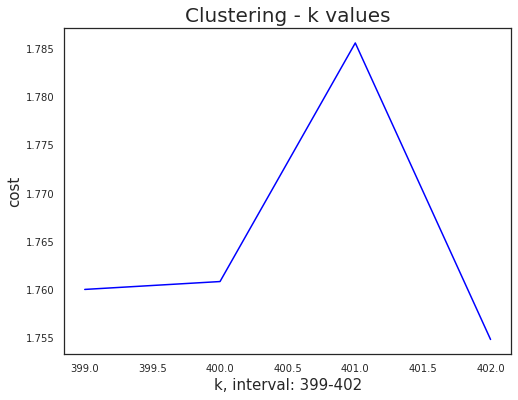

In [34]:
# Test different k for clustering

k_interval = (399,402)
cost = [0] * (k_interval[1]-k_interval[0]+1)
for k in range(k_interval[0],k_interval[1]+1):
    kmeans = KMeans(k=k,seed=1, featuresCol='position_scaledFeatures', predictionCol='cluster_position')
    model = kmeans.fit(trainSet)
    k_cost = model.computeCost(testSet)
    cost[k-k_interval[0]] = k_cost
    print("Clustering","k: "+ str(k)+  " Cost: " + str(k_cost))
    logger.write2file("Clustering","k: "+ str(k)+  " Cost: " + str(k_cost))
    
if enable_plots:
    fig, ax = plt.subplots(1,1, figsize =(8,6))
    b = sns.lineplot(range(k_interval[0],k_interval[1]+1),cost, color='blue')
    b.axes.set_title("Clustering - k values",fontsize=20)
    b.set_xlabel('k, interval: ' + str(k_interval[0]) + '-' + str(k_interval[1]),fontsize=15)
    b.set_ylabel('cost',fontsize=15)
    b.tick_params(labelsize=10) 

    logger.saveImage(b,"Clustering_k_values")

In [35]:
# Test the model with actual numbers
number_of_clusters= 400

kmeans = KMeans(k=number_of_clusters, featuresCol='position_scaledFeatures', predictionCol='cluster_position')
cluster_model = kmeans.fit(trainSet)
predictions = cluster_model.transform(testSet)

evaluator = ClusteringEvaluator(featuresCol='position_scaledFeatures', predictionCol='cluster_position')

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Transform the hole dataset
df = cluster_model.transform(preprocessed_cord)
df.select('Start_Lat','Start_Lng','position_scaledFeatures','cluster_position').show(5,False)

logger.write2fileModel(cluster_model, "Cluster_Model")

Silhouette with squared euclidean distance = 0.5961442682312187
+---------+-----------+----------------------------------------+----------------+
|Start_Lat|Start_Lng  |position_scaledFeatures                 |cluster_position|
+---------+-----------+----------------------------------------+----------------+
|38.0853  |-122.233017|[0.5857438439023317,0.21591212883417535]|360             |
|37.631813|-122.084167|[0.5378201613050668,0.23096819129908389]|30              |
|37.896564|-122.070717|[0.565798566179536,0.23232864840457856] |318             |
|37.334255|-122.032471|[0.506374772250304,0.23619720174709027] |277             |
|37.250729|-121.910713|[0.4975478962591088,0.24851292934938926]|347             |
+---------+-----------+----------------------------------------+----------------+
only showing top 5 rows

Saving into: models/CA_20200518223811/Cluster_Model
'function' object has no attribute 'format'
Saving through format 2


+-----------------------+----------------+------------------+-------------------+
|position_scaledFeatures|cluster_position|                 x|                  y|
+-----------------------+----------------+------------------+-------------------+
|   [0.58574384390233...|             360|0.5857438439023317|0.21591212883417535|
|   [0.53782016130506...|              30|0.5378201613050668|0.23096819129908389|
|   [0.56579856617953...|             318| 0.565798566179536|0.23232864840457856|
|   [0.50637477225030...|             277| 0.506374772250304|0.23619720174709027|
|   [0.49754789625910...|             347|0.4975478962591088|0.24851292934938926|
+-----------------------+----------------+------------------+-------------------+
only showing top 5 rows



No handles with labels found to put in legend.


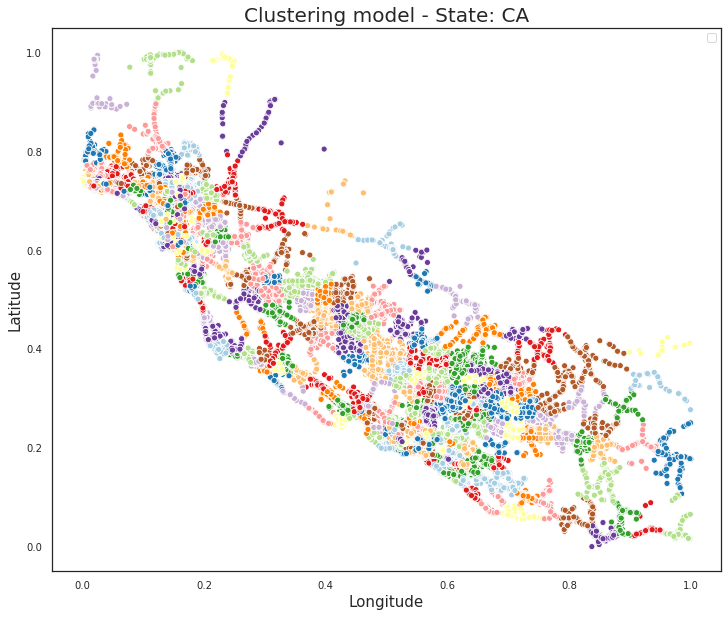

In [36]:
# Display the different clusters based on the final clustering model
if enable_plots:
    
    tmp_df_pos = df.select('position_scaledFeatures', 'cluster_position')
    # Split coordinates
    tmp_df_pos = tmp_df_pos.withColumn("x", udf(lambda c: float(c[0]), DoubleType())('position_scaledFeatures'))
    tmp_df_pos = tmp_df_pos.withColumn("y", udf(lambda c: float(c[1]), DoubleType())('position_scaledFeatures'))
    tmp_df_pos.show(5)
    pd_df_pos = tmp_df_pos.toPandas()
    
    fig, ax = plt.subplots(1,1, figsize =(12,10))
    
    b = sns.scatterplot(x="x", y="y", hue="cluster_position", data=pd_df_pos,palette="Paired",legend=None)
    b.axes.set_title("Clustering model - State: " + filter_state ,fontsize=20)
    b.set_xlabel('Longitude',fontsize=15)
    b.set_ylabel('Latitude',fontsize=15)
    b.tick_params(labelsize=10) 
    plt.gca().legend().set_title('')
    
    logger.saveImage(b,"Clustering_centroids")

In [37]:
df.show(1)
logger.write2file("Dataset after adding quantiles",str(df.take(1)))

+-----+--------+-------------------+---------+-----------+------------+------+-----------+----+-------+------+-----+-------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----------+-----------+------------+-------------+--------------------+-----------------------+----------------+
|  TMC|Severity|         Start_Time|Start_Lat|  Start_Lng|Distance(mi)|Number|     Street|Side|   City|County|State|Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout

## Cast data 
#Cast all the datacolumns into correct format so they will be sorted to numerical or categorical values. Data removed caused to big feature vector, contained too #many NaN values or were converted into another form.

In [38]:
# Could be handles as separated lists and then sent to a UDF for processing but since low number of features and easier to visualize this select is kept.
df = df.select(
        col('Severity').cast('int'),
        col('Start_Hour').cast('string'),
        col('Start_Month').cast('string'),
        col('Weather_Hour').cast('string'),
        col('Weather_Month').cast('string'),
        col('cluster_position').cast('string'),
        col('Distance(mi)').cast('double'),
        col('Side').cast('string'),   
        col('Temperature(F)').cast('double'),
        col('Wind_Chill(F)').cast('double'), 
        col('Humidity(%)').cast('double'),
        col('Pressure(in)').cast('double'),
        col('Visibility(mi)').cast('double'),
        col('Wind_Direction').cast('string'),
        col('Wind_Speed(mph)').cast('double'), 
        col('Weather_Condition').cast('string'),
        col('Amenity').cast('string'),
        col('Bump').cast('string'),
        col('Crossing').cast('string'),
        col('Give_Way').cast('string'),
        col('Junction').cast('string'),
        col('No_Exit').cast('string'),
        col('Railway').cast('string'),
        col('Roundabout').cast('string'),
        col('Station').cast('string'),
        col('Stop').cast('string'),
        col('Traffic_Calming').cast('string'),
        col('Traffic_Signal').cast('string'),
        col('Turning_Loop').cast('string'),
        col('Sunrise_Sunset').cast('string'),
        col('Civil_Twilight').cast('string'),
        col('Nautical_Twilight').cast('string'),
        col('Astronomical_Twilight').cast('string')
    ) 

colLabel = ["Severity"]

colCat, colNum = createNewClasses(df, sc, colLabel)
logger.write2file("Categorical groups","Defined Label:\n" + str(colLabel) + "\nDefined Categories:\n" + str(colCat) + "\nDefined Numerical:\n" +str(colNum))

Label: ['Severity'] 
Categories: ['Start_Hour', 'Start_Month', 'Weather_Hour', 'Weather_Month', 'cluster_position', 'Side', 'Wind_Direction', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
Numerical: ['Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']


## Get categorical values

In [39]:
df.persist()
tmp = [df.select(countDistinct(c).alias(c)).collect()[0] for c in [*colCat]] 
df.unpersist()
print("Unique column values:", tmp)

logger.write2file("Unique column values", str(tmp))

Unique column values: [Row(Start_Hour=24), Row(Start_Month=12), Row(Weather_Hour=24), Row(Weather_Month=12), Row(cluster_position=400), Row(Side=3), Row(Wind_Direction=24), Row(Weather_Condition=69), Row(Amenity=2), Row(Bump=2), Row(Crossing=2), Row(Give_Way=2), Row(Junction=2), Row(No_Exit=2), Row(Railway=2), Row(Roundabout=2), Row(Station=2), Row(Stop=2), Row(Traffic_Calming=2), Row(Traffic_Signal=2), Row(Turning_Loop=1), Row(Sunrise_Sunset=2), Row(Civil_Twilight=2), Row(Nautical_Twilight=2), Row(Astronomical_Twilight=2)]


## Clean data

### Recheck the missing values
#Check so that the output contains 0 missing values

In [40]:
df.persist()
printMissingValues(df,logger)
df.unpersist()

Missing values[Row(Severity=0, Start_Hour=196, Start_Month=196, Weather_Hour=9292, Weather_Month=9292, cluster_position=0, Distance(mi)=0, Side=0, Temperature(F)=14956, Wind_Chill(F)=471554, Humidity(%)=16139, Pressure(in)=11097, Visibility(mi)=13058, Wind_Direction=11924, Wind_Speed(mph)=128584, Weather_Condition=12730, Amenity=0, Bump=0, Crossing=0, Give_Way=0, Junction=0, No_Exit=0, Railway=0, Roundabout=0, Station=0, Stop=0, Traffic_Calming=0, Traffic_Signal=0, Turning_Loop=0, Sunrise_Sunset=6, Civil_Twilight=6, Nautical_Twilight=6, Astronomical_Twilight=6)]


DataFrame[Severity: int, Start_Hour: string, Start_Month: string, Weather_Hour: string, Weather_Month: string, cluster_position: string, Distance(mi): double, Side: string, Temperature(F): double, Wind_Chill(F): double, Humidity(%): double, Pressure(in): double, Visibility(mi): double, Wind_Direction: string, Wind_Speed(mph): double, Weather_Condition: string, Amenity: string, Bump: string, Crossing: string, Give_Way: string, Junction: string, No_Exit: string, Railway: string, Roundabout: string, Station: string, Stop: string, Traffic_Calming: string, Traffic_Signal: string, Turning_Loop: string, Sunrise_Sunset: string, Civil_Twilight: string, Nautical_Twilight: string, Astronomical_Twilight: string]

### Remove data with occurance less than 1%
#Based on information from analysis. With further analysis lower procentage can be used to find better results.

In [41]:
df.persist()
original_rows = df.count()
n = int(df.count()*0.001) # Limit the plot to ignore conditions below an limit

weather_freq = df.groupBy('Weather_Condition').count().orderBy('count',ascending=False)
df_filtered = weather_freq.filter(weather_freq['count'] > n)
filtered_conditions = df_filtered.select("Weather_Condition").rdd.flatMap(lambda x: x).collect()
df = df.filter(df['Weather_Condition'].isin(*filtered_conditions))

df_filtered.show()
removed_rows = original_rows - df.count()

df.unpersist()
print("Rows removed:",removed_rows)

logger.write2file("Weather condition", str(df_filtered.take(df_filtered.count())) + "\nRows removed: " + str(removed_rows))

+-----------------+------+
|Weather_Condition| count|
+-----------------+------+
|            Clear|253070|
|             Fair| 96006|
|    Mostly Cloudy| 59929|
|    Partly Cloudy| 58523|
|         Overcast| 58472|
| Scattered Clouds| 29356|
|           Cloudy| 24063|
|             Haze| 21561|
|       Light Rain| 20421|
|             null| 12730|
|             Rain|  6438|
|              Fog|  4100|
|       Heavy Rain|  2246|
|            Smoke|  1921|
|     Fair / Windy|  1179|
+-----------------+------+

Rows removed: 15887


# Remove if distict values in category equals 1

In [42]:
df.persist()
tmp = [c for c in [*colCat] if df.select(countDistinct(c)).collect()[0][0] <= 1] 
df.unpersist()

[colCat.remove(c) for c in tmp]
print("Dropping columns with 1 class:", tmp)
logger.write2file("Dropping columns with 1 class", str(tmp))

Dropping columns with 1 class: ['Turning_Loop']


## Prepare Pipeline

In [43]:
imputer = Imputer(inputCols=colNum, outputCols=colNum)
imputer.setStrategy("median")

num_assembler = VectorAssembler(inputCols=colNum, outputCol="num_features")
scaler = MinMaxScaler(min=0.0, max=1.0, inputCol="num_features", outputCol="scaledFeatures")

indexers = [StringIndexer(inputCol = c, outputCol = c +'_IDX', handleInvalid='skip') for c in colCat]

encoder = OneHotEncoderEstimator(inputCols=[indexer.getOutputCol() for indexer in indexers], outputCols=["{0}_vec".format(indexer.getOutputCol()) for indexer in indexers])

## Preprocessing - Pipeline

In [44]:
# Categorical values

numPipeline = Pipeline(stages=[imputer, num_assembler, scaler])
catPipeline = Pipeline(stages=[*indexers, encoder])

pipeline = Pipeline(stages=[numPipeline, catPipeline])

preprocessed_Model = pipeline.fit(df)
preprocessed_df = preprocessed_Model.transform(df)

In [45]:
preprocessed_df.select("scaledFeatures",*[c + "_IDX_vec" for c in colCat]).show(1,False)

+---------------------------------------------------------------------------------------------------------------------------+------------------+-------------------+--------------------+---------------------+------------------------+-------------+----------------------+-------------------------+---------------+-------------+----------------+----------------+----------------+---------------+---------------+------------------+---------------+-------------+-----------------------+----------------------+----------------------+----------------------+-------------------------+-----------------------------+
|scaledFeatures                                                                                                             |Start_Hour_IDX_vec|Start_Month_IDX_vec|Weather_Hour_IDX_vec|Weather_Month_IDX_vec|cluster_position_IDX_vec|Side_IDX_vec |Wind_Direction_IDX_vec|Weather_Condition_IDX_vec|Amenity_IDX_vec|Bump_IDX_vec |Crossing_IDX_vec|Give_Way_IDX_vec|Junction_IDX_vec|No_Exit_IDX_vec|R

## Combine features

In [46]:
va2 = VectorAssembler(inputCols=["scaledFeatures", *[c + "_IDX_vec" for c in colCat]], outputCol="final_features")

df = va2.transform(preprocessed_df)
df.persist()
df = df.withColumn('label', col("Severity"))
df = df.withColumn('features', df.final_features).select("features","label")
df.unpersist()

logger.write2file("Feature set size", str(df.count()) + "\n\n__Feature vector and label:__\n" + str(df.take(1)))
logger.write2file("Number of rows", str(df.count()))
print("Feature set size: ",df.count())

Feature set size:  635496


# 3. Feature importance

## PCA
#After editing Quantilization PCA started to crash by giving error: spark.driver.maxResultSize
#In order to understand how much the variance affect the dataset we check with PCA. Try to get above 90%

In [47]:
length_of_feature_vec = 250
pca = PCA(k=length_of_feature_vec, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df)
pca_df = pca_model.transform(df)


print("PCA - Feature Variance:","Top 50:\n" + str(pca_model.explainedVariance[:50]) + "\nNumber of items: "+str(length_of_feature_vec)+"\nSum of variance: "+ str(sum(pca_model.explainedVariance)))
logger.write2file("PCA - Feature variance", "Top 50:\n" + str(pca_model.explainedVariance[:50]) + "\nNumber of items: "+ str(length_of_feature_vec) +"\nSum of variance: "+ str(sum(pca_model.explainedVariance)))
logger.write2fileModel(pca_model, "pca_Model")

PCA - Feature Variance: Top 50:
[0.09517885 0.042329   0.03187951 0.02992827 0.02626255 0.02584466
 0.02482019 0.02432244 0.02169964 0.02106223 0.01971552 0.01911814
 0.01864132 0.01732295 0.01655663 0.0155096  0.01488342 0.0147133
 0.01381792 0.01375529 0.01310705 0.01297893 0.01252759 0.01216059
 0.01196073 0.01160589 0.01129529 0.01100549 0.01055536 0.01033982
 0.00993728 0.00958632 0.00940934 0.00864369 0.00854187 0.00800695
 0.00739388 0.00730541 0.0070265  0.00665409 0.00656646 0.00617706
 0.00588754 0.00584305 0.00550262 0.00537009 0.00485882 0.00478539
 0.00463014 0.00446781]
Number of items: 250
Sum of variance: 0.9677127321907768
Saving into: models/CA_20200518223811/pca_Model
'function' object has no attribute 'format'
Saving through format 2


## ChiSqSelector
#Check top 100 which of the values in the feature vector

In [48]:
selector = ChiSqSelector(numTopFeatures=length_of_feature_vec, 
                         labelCol='label', 
                         featuresCol='features', 
                         outputCol="selectedFeatures",
                         selectorType='numTopFeatures', 
                         percentile=0.1, 
                         fpr=0.05, fdr=0.05, fwe=0.05)

chi_model = selector.fit(df)
chi_df = chi_model.transform(df)

logger.write2file("Top selected features according to ChiSqSelector", str(chi_model.selectedFeatures)+ "\nNumber of features: " + str(length_of_feature_vec) + "\nExample data:\n"+str(chi_df.take(5)))
logger.write2fileModel(chi_model, "chi_Model")

print("Top selected features according to ChiSqSelector:", chi_model.selectedFeatures)
print("Transformed selected features:",chi_df.head().selectedFeatures)


Saving into: models/CA_20200518223811/chi_Model
'function' object has no attribute 'format'
Saving through format 2
Top selected features according to ChiSqSelector: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 49, 51, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 94, 101, 102, 104, 105, 106, 107, 109, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 144, 145, 146, 148, 149, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 165, 166, 167, 168, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 185, 186, 187, 188, 189, 190, 191, 192, 194, 196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 213, 215, 216, 218, 219, 221, 222, 223, 224, 225, 226, 228, 22

In [49]:
df = chi_df.withColumn('features', col('selectedFeatures')).select('label', 'features')
df.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    3|(250,[1,2,3,4,5,6...|
|    3|(250,[1,2,3,4,5,6...|
|    2|(250,[1,2,3,4,5,6...|
|    3|(250,[1,2,3,4,5,6...|
|    2|(250,[1,2,3,4,5,6...|
+-----+--------------------+
only showing top 5 rows



# 4. Machine learning

In [50]:
trainSet, testSet = df.randomSplit([0.8 ,0.2], 1)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

In [51]:
trainSet.show(2,False)

+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                                       |
+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1    |(250,[0,1,2,3,4,5,6,7,25,36,51],[4.4012146052121174E-5,0.642085187539733,0.6379044684129429,0.43434343434343436,0.9105070250458154,0.07142857142857142,0.021025765678172097,1.0,1.0,1.0,1.0])  |
|1    |(250,[0,1,2,3,4,5,6,7,28,36,110],[4.4012146052121174E-5,0.49523204068658616,0.6379044684129429,0.7878787878787878,0.9172266340867439,0.07142857142857142,0.005590666018473505,1.0,1.0,1.0,1.0])|


## Logistic regression

In [52]:
lr = LogisticRegression(labelCol="label", featuresCol="features")

paramGrid = ParamGridBuilder() \
                .addGrid(lr.regParam, [0.1,0.01]) \
                .addGrid(lr.maxIter, [10]) \
                .addGrid(lr.elasticNetParam, [0.6]) \
                .build()

_, _ = evaluateModel(lr, paramGrid, "LR_Model", trainSet, testSet, evaluator=MulticlassClassificationEvaluator(),k=10, seed=None,logger=logger)

Fitting model..
Predicting on testSet..
Evaluating predictions..
Saving into: models/CA_20200518223811/LR_Model
'function' object has no attribute 'format'
Saving through format 2
+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       2.0|    1|(250,[0,1,2,3,4,5...|
|       2.0|    1|(250,[0,1,2,3,4,5...|
|       2.0|    1|(250,[0,1,2,3,4,5...|
|       2.0|    1|(250,[0,1,2,3,4,5...|
|       2.0|    1|(250,[0,1,2,3,4,5...|
+----------+-----+--------------------+
only showing top 5 rows

Accuracy:  0.6586204163735002 
Parameters
 {Param(parent='LogisticRegression_27f5be0fe873', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_27f5be0fe873', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='LogisticRegression_27f5be0fe873', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty

## Decision tree

In [53]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features") 

paramGrid = ParamGridBuilder().build()

_, _ = evaluateModel(dt, paramGrid, "DT_Model", trainSet, testSet, evaluator=MulticlassClassificationEvaluator(),k=10, seed=None,logger=logger)

Fitting model..
Predicting on testSet..
Evaluating predictions..
Saving into: models/CA_20200518223811/DT_Model
'function' object has no attribute 'format'
Saving through format 2
+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       2.0|    1|(250,[0,1,2,3,4,5...|
|       2.0|    1|(250,[0,1,2,3,4,5...|
|       2.0|    1|(250,[0,1,2,3,4,5...|
|       2.0|    1|(250,[0,1,2,3,4,5...|
|       2.0|    1|(250,[0,1,2,3,4,5...|
+----------+-----+--------------------+
only showing top 5 rows

Accuracy:  0.5606696586405385 
Parameters
 {}
Confusion matrix: DenseMatrix([[8.4540e+04, 3.9472e+04, 1.0800e+03],
             [4.4600e+02, 1.5490e+03, 1.0500e+02],
             [0.0000e+00, 0.0000e+00, 1.0000e+00]])


## Random forest

In [54]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features") #numTrees=10
paramGrid = ParamGridBuilder() \
                .addGrid(rf.numTrees,[15]) \
                .build()

_, _ = evaluateModel(rf, paramGrid, "RF_Model", trainSet, testSet, evaluator=MulticlassClassificationEvaluator(),k=10, seed=None,logger=logger)

Fitting model..
Predicting on testSet..
Evaluating predictions..
Saving into: models/CA_20200518223811/RF_Model
'function' object has no attribute 'format'
Saving through format 2
+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       2.0|    1|(250,[0,1,2,3,4,5...|
|       2.0|    1|(250,[0,1,2,3,4,5...|
|       2.0|    1|(250,[0,1,2,3,4,5...|
|       2.0|    1|(250,[0,1,2,3,4,5...|
|       2.0|    1|(250,[0,1,2,3,4,5...|
+----------+-----+--------------------+
only showing top 5 rows

Accuracy:  0.5349772113574066 
Parameters
 {Param(parent='RandomForestClassifier_265571b3dcae', name='numTrees', doc='Number of trees to train (>= 1).'): 15}
Confusion matrix: DenseMatrix([[84986.]])



In [55]:
logger.write2file("Program finished!", "")

In [56]:
logger.write2file("New model folder created", \
               "Model finished: Yes" + \
               "\nFolder name: " + logger.timeSignature + \
               "\nState: "+ filter_state + \
               "\nLogs directory: " + logger.logs_dir +  \
               "\nFile: " + file + \
               "\nNote: " + model_Note, \
               logs_dir=model_indexing_dir \
              )


In [57]:
#sc.stop()